In [4]:
# import necessary modules
# uncomment to get plots displayed in notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
from scipy.optimize import fsolve
import math
# from tqdm.notebook import trange, tqdm #controlling iteration speed
import matplotlib.ticker as mticker
%run Effective_Degrees_of_Freedom.ipynb

In [6]:
# esthetic definitions for the plots
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
# matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

def multicolor_ylabel(ax,list_of_strings,list_of_colors,axis='x',anchorpad=0,**kw):
    """this function creates axes labels with multiple colors
    ax specifies the axes object where the labels should be drawn
    list_of_strings is a list of all of the text items
    list_if_colors is a corresponding list of colors for the strings
    axis='x', 'y', or 'both' and specifies which label(s) should be drawn"""
    from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

    # x-axis label
    if axis=='x' or axis=='both':
        boxes = [TextArea(text, textprops=dict(color=color, ha='left',va='bottom',**kw)) 
                    for text,color in zip(list_of_strings,list_of_colors) ]
        xbox = HPacker(children=boxes,align="center",pad=0, sep=5)
        anchored_xbox = AnchoredOffsetbox(loc=3, child=xbox, pad=anchorpad,frameon=False,bbox_to_anchor=(0.2, -0.09),
                                          bbox_transform=ax.transAxes, borderpad=0.)
        ax.add_artist(anchored_xbox)

    # y-axis label
    if axis=='y' or axis=='both':
        boxes = [TextArea(text, textprops=dict(color=color, ha='left',va='bottom',rotation=90,**kw)) 
                     for text,color in zip(list_of_strings[::-1],list_of_colors) ]
        ybox = VPacker(children=boxes,align="center", pad=0, sep=5)
        anchored_ybox = AnchoredOffsetbox(loc=3, child=ybox, pad=anchorpad, frameon=False, bbox_to_anchor=(-0.13, 0.4), 
                                          bbox_transform=ax.transAxes, borderpad=0.)
        ax.add_artist(anchored_ybox)
        

Input below, plug in present value of comoving axion number density $Y_a$, present density parameter of photons $\omega_\gamma$(`omega_gamma` here can be obtained from class via `(.)rho_g` in `background`) and axion mass $m_a$ in eV and axion decoupling temperature $T_{a, dec}$ in GeV for now. 
The code will then compute the expected present value of $\omega_a$ and also use it as input i.e `omega_ncdm`.
In the future the present temperature of axions $T_a$ (`T_ncdm`) should be computed as a function of $T_{a, dec}$, right now it assumes decoupling at around 100 GeV. For that we need to implement the function $g_{*s}(T)$, preferably via 1609.04979. 

In [7]:
### INPUT ###
Y_a = 0.0122
omega_gamma = 2.473e-5
axion_mass = 0.6 #eV
axion_decoupling_temp = 200 #GeV --> g_star = 45.47 (or 61.99) from 1609.04979
###
common_settings = { # No output needed here
                    # LambdaCDM parameters
                   'h':0.67810,
                   'omega_b':0.02238280,
                   'omega_cdm':0.1201075,
                   'YHe': 0.2448, #so that it computes large DeltaN, I don't think it matters much 
                   # Axion ncDM parameters 
                   'N_ncdm': 1,
                   'omega_ncdm': ((100/12)*Y_a)**(4/3)*omega_gamma,
                   'T_ncdm': (3.91/45.47)**(1/3), # (g_star(T_0)/g_star(T_dec))^(1/3)  
                   'm_ncdm': axion_mass
                   }  

The formula used for plotting axion comoving number density is
$$ g_{*s}Y_a = \frac{2\pi^4}{45\zeta(3)} \left(\frac{2\rho_a}{\rho_\gamma}\right)^{3/4}=\frac{2\pi^4}{45\zeta(3)} \left(\frac{2\Omega_a}{\Omega_\gamma}\right)^{3/4}$$
The values that `CLASS` obtains are $\rho_a$ as `(.)rho_ncdm[0]` and $\rho_\gamma$ as `(.)rho_g` from the `background` module.

In [8]:
### Run Class ###
AxionCLASS = Class()
AxionCLASS.set(common_settings)
AxionCLASS.compute()

bgAxion=AxionCLASS.get_background()
thAxion=AxionCLASS.get_thermodynamics()
print(bgAxion.keys())
print(thAxion.keys())
proper_time = bgAxion['proper time [Gyr]']
z = bgAxion['z']
a = thAxion['scale factor a'] #a and z lists from thermodynamics.c module and z from background.c module have different lengths
z2 = thAxion['z']

rho_ncdm = bgAxion['(.)rho_ncdm[0]']
rho_g = bgAxion['(.)rho_g']

#Compute g_{*s}Y_a
gY_a=(2*rho_ncdm/rho_g)**(3/4)*(45 * 1.202) / (2*np.pi**4)
Y_a = gY_a/g_star(proper_time)

dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_ncdm[0]', '(.)p_ncdm[0]', '(.)rho_lambda', '(.)rho_ur', '(.)rho_crit', '(.)rho_tot', '(.)p_tot', '(.)p_tot_prime', 'gr.fac. D', 'gr.fac. f'])
dict_keys(['scale factor a', 'z', 'conf. time [Mpc]', 'x_e', "kappa' [Mpc^-1]", 'exp(-kappa)', 'g [Mpc^-1]', 'Tb [K]', 'dTb [K]', 'w_b', 'c_b^2', 'tau_d'])


First let's plot $a(z)$ and $g_{\star s}Y_a(z)$ to see the impact of era transition on the evolution.

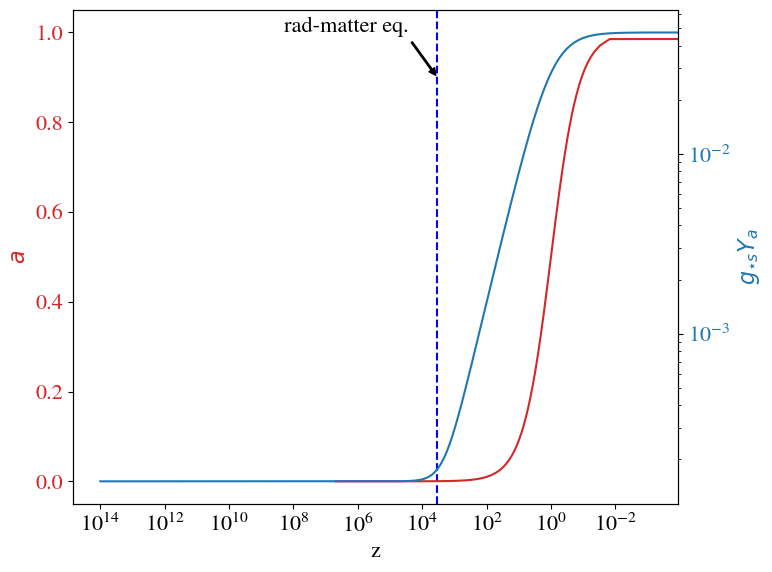

In [9]:
### PLOTTING 1 ###
fig, ax1 = plt.subplots()
ax1.axvline(x = 3400, color = 'b', linestyle = '--') #matter-radiation equality

plt.annotate(r'rad-matter eq.',
                xy=(3400,0.9),
                xytext=(2e8,1),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1, headlength=5, headwidth=5))

ax1.invert_xaxis() #time goes to the right

#Plot a(z)
color = 'tab:red'
ax1.set_xlabel('z')
ax1.set_ylabel('$a$', color=color)
ax1.semilogx(z2, a, color=color)
ax1.tick_params(axis='y', labelcolor=color)

#Plot g_{*s}Y_a(z)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('$g_{\star s}Y_a$', color=color)  # we already handled the x-label with ax1
ax2.loglog(z, gY_a, color=color)
ax2.set_xscale('log')
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

And now let's plot $g_{\star s}$, $g_{\star s}Y_a$ and $Y_a$ to compare them.

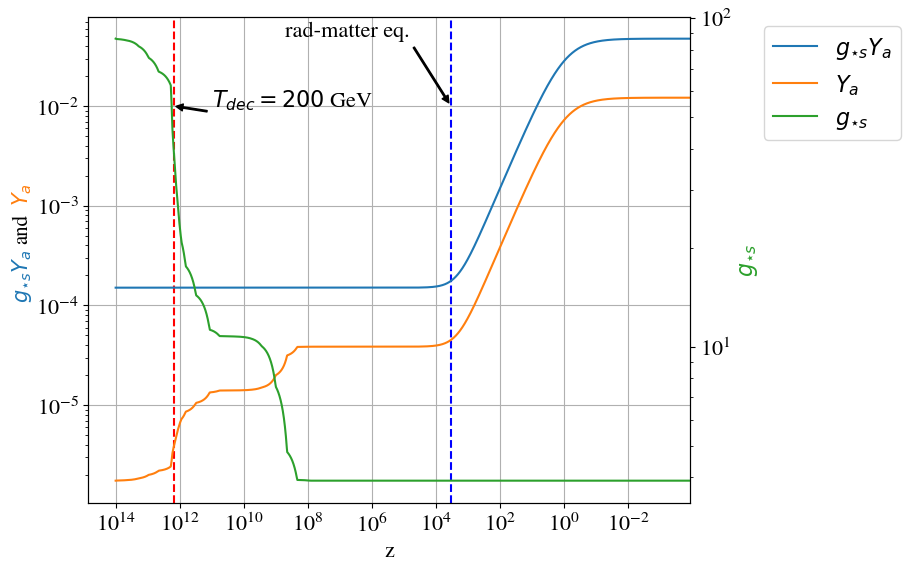

In [10]:
### PLOTTING 2 ###
fig, ax3 = plt.subplots()
ax3.axvline(x = 3400, color = 'b', linestyle = '--') #matter-radiation equality
ax3.axvline(x = 1.5e12, color = 'r', linestyle = '--') #around T=200 GeV

plt.annotate(r'rad-matter eq.',
                xy=(3400,1e-2),
                xytext=(1+5e8,5e-2),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1, headlength=5, headwidth=5))

plt.annotate(r'$T_{dec}= 200$ GeV',
                xy=(1.5e12,1e-2),
                xytext=(1+1e11,1e-2),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1, headlength=5, headwidth=5))

ax3.invert_xaxis() #time goes to the right
#ax1.set_xlim(max(z2), min(z2[1:]))

#Plot a(z)
color = 'tab:red'
ax3.set_xlabel('z')
multicolor_ylabel(ax3, ['$g_{\star s}Y_a$','and',  '$Y_a$'], ['tab:orange', 'black', 'tab:blue'], axis='y', size=15)
ax3.loglog(z, gY_a, label = '$g_{\star s}Y_a$')
ax3.loglog(z, Y_a, label = '$Y_a$')
ax3.tick_params(axis='y')

#Plot g_{*s}
ax4 = ax3.twinx()  # instantiate a second axes that shares the same x-axis
#ax2.set_xlim(max(z2), min(z2[1:]))
color = 'tab:green'
ax4.set_ylabel('$g_{\star s}$', color=color)  # we already handled the x-label with ax1
ax4.loglog(z, g_star(proper_time), color=color, label = '$g_{\star s}$')
#ax2.loglog(z, Y_a, color = 'g')
ax4.tick_params(axis='y')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax3.grid()
fig.legend(bbox_to_anchor=(1.16, 0.95))
plt.show()